In [ ]:
!pip install pm4py

drive = True
dir = './data/'
if drive:
  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

  import sys
  sys.path.insert(0,'/content/drive/My Drive/Masterthesis')

  dir = '/content/drive/My Drive/Masterthesis/'

import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import pm4py


def import_xes(file_path):
    event_log = pm4py.read_xes(file_path)
    event_log['time:timestamp'] = pd.to_datetime(event_log['time:timestamp'], utc=True)
    return event_log


event_log_path = 'output/Sepsis_alpha10_b1_gamma0.049999999999999996_epsilon40_delta0.001.xes'

In [3]:
# Read event_log from XES file and preprocess
event_log = import_xes(dir + event_log_path)

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/105 [00:00<?, ?it/s]

In [4]:
print(event_log.head())
print(event_log.columns)
print(event_log[['concept:name', 'case:concept:name', 'time:timestamp']])

       concept:name            time:timestamp             org_timestamp  \
0   ER Registration 2014-10-15 02:20:24+00:00 2014-10-14 21:06:51+00:00   
1         ER Triage 2014-10-15 02:42:16+00:00 2014-10-14 21:28:18+00:00   
2  ER Sepsis Triage 2014-10-15 02:41:49+00:00 2014-10-14 21:28:35+00:00   
3   ER Registration 2014-05-11 11:03:31+00:00 2014-05-11 12:09:29+00:00   
4         ER Triage 2014-05-11 11:15:22+00:00 2014-05-11 12:21:10+00:00   

   start_event case:concept:name  
0         True               RV0  
1        False               RV0  
2        False               RV0  
3         True              KDA0  
4        False              KDA0  
Index(['concept:name', 'time:timestamp', 'org_timestamp', 'start_event',
       'case:concept:name'],
      dtype='object')
         concept:name case:concept:name            time:timestamp
0     ER Registration               RV0 2014-10-15 02:20:24+00:00
1           ER Triage               RV0 2014-10-15 02:42:16+00:00
2    ER Sepsis Tr

In [5]:
# cols specifies the attributes which should be taken into account to compute the uniqueness
def compute_uniqueness(df, cols):
    amount_cases = df.shape[0]
    unique_values_in_column = df[cols].drop_duplicates().shape[0]
    uniqueness_of_col = round(unique_values_in_column / amount_cases, 4) * 100
    return uniqueness_of_col

In [6]:
# Now let's focus on the uniqueness of traces
case_identifier = 'case:concept:name'
event_identifier = 'concept:name'
df_events_per_case = event_log.groupby(case_identifier)[event_identifier].agg(lambda x: ', '.join(str(val).strip() for val in x if pd.notna(val))).reset_index()
df_events_per_case

,case:concept:name,concept:name
0,1516,"ER Registration, ER Triage, ER Sepsis Triage, ..."
1,158,"ER Registration, ER Triage, ER Sepsis Triage, ..."
2,1712,"ER Registration, ER Triage, ER Sepsis Triage, ..."
3,1718,"ER Registration, ER Triage, ER Sepsis Triage"
4,176,"ER Registration, ER Triage, ER Sepsis Triage, ..."
...,...,...
100,WMA17,"ER Registration, ER Triage, ER Sepsis Triage, ..."
101,WY2,"ER Registration, ER Triage, ER Sepsis Triage"
102,XA8,"ER Registration, ER Triage, ER Sepsis Triage"
103,XIA10,"ER Registration, ER Triage, ER Sepsis Triage, ..."


In [7]:
uniqueness_of_traces = compute_uniqueness(df_events_per_case, event_identifier)
print("{} %".format(uniqueness_of_traces))

2.86 %


In [8]:
# Compute the uniqueness of each activity --> With which probability can I reidentify a case (trace) given that a specific activity is contained in the trace
total_amount_traces = df_events_per_case.shape[0]
total_amount_events = event_log[event_identifier].unique().shape[0]
all_events = event_log[event_identifier].unique()
uniqueness_containing_activity = pd.DataFrame(all_events, columns=[event_identifier])
counts = {}
appears = {}

def helper_count(row, activity_code):
    total_counts = str(row).count(str(activity_code))
    return 1 if total_counts > 0 else 0

for event in all_events:
    counts[str(event)] = int(df_events_per_case[event_identifier].apply(lambda row: str(row).count(str(event))).values.sum())
    appears[str(event)] = df_events_per_case[event_identifier].apply(lambda row: helper_count(row, event)).values.sum()

df_unique_events = pd.DataFrame([counts.keys(), counts.values(), appears.values()]).T
df_unique_events.columns = [event_identifier, 'total counts', 'containedInTrace']

# Compute uniqueness
df_unique_events['uniqueness'] = 1 - (df_unique_events['containedInTrace'] - 1) / total_amount_traces

print(df_unique_events.sort_values('uniqueness', ascending=False))

       concept:name total counts containedInTrace uniqueness
3        Leucocytes           57               57   0.466667
4               CRP           57               57   0.466667
0   ER Registration          105              105   0.009524
1         ER Triage          105              105   0.009524
2  ER Sepsis Triage          105              105   0.009524


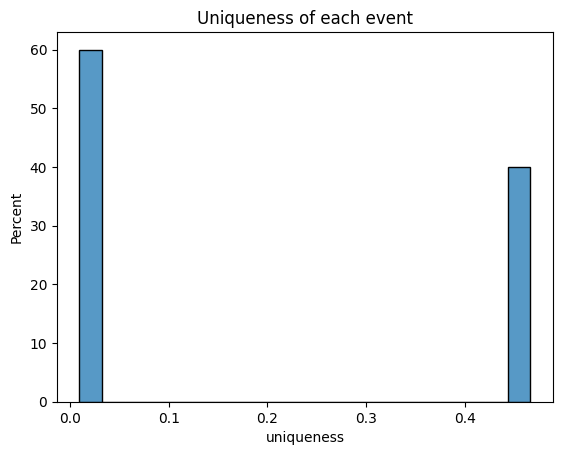

Bin 1 -  Count: 3, Percentage: 60.0 %
Bin 2 -  Count: 0, Percentage: 0.0 %
Bin 3 -  Count: 0, Percentage: 0.0 %
Bin 4 -  Count: 0, Percentage: 0.0 %
Bin 5 -  Count: 0, Percentage: 0.0 %
Bin 6 -  Count: 0, Percentage: 0.0 %
Bin 7 -  Count: 0, Percentage: 0.0 %
Bin 8 -  Count: 0, Percentage: 0.0 %
Bin 9 -  Count: 0, Percentage: 0.0 %
Bin 10 -  Count: 0, Percentage: 0.0 %
Bin 11 -  Count: 0, Percentage: 0.0 %
Bin 12 -  Count: 0, Percentage: 0.0 %
Bin 13 -  Count: 0, Percentage: 0.0 %
Bin 14 -  Count: 0, Percentage: 0.0 %
Bin 15 -  Count: 0, Percentage: 0.0 %
Bin 16 -  Count: 0, Percentage: 0.0 %
Bin 17 -  Count: 0, Percentage: 0.0 %
Bin 18 -  Count: 0, Percentage: 0.0 %
Bin 19 -  Count: 0, Percentage: 0.0 %
Bin 20 -  Count: 2, Percentage: 40.0 %

0 activities are completely unique


In [9]:
def print_and_visualize_hist_plot(df, col_name, amount_bins, hist_title, total_amount):

    sns.histplot(df[col_name], bins=amount_bins, stat='percent').set(title=hist_title)
    plt.show()

    hist_values, bin_edges = np.histogram(df[col_name], bins=amount_bins)

    # Print out the histogram values
    for i in range(len(hist_values)):
        print(f"Bin {i+1} -  Count: {hist_values[i]}, Percentage: {round(hist_values[i]/total_amount, 4) * 100} %")

    # Count of activities which have a uniqueness of 100%
    amount_completely_unique_activities = df[df[col_name] == 1][col_name].count()
    print("\n{} activities are completely unique".format(amount_completely_unique_activities))

print_and_visualize_hist_plot(df=df_unique_events, col_name='uniqueness', amount_bins=20, hist_title='Uniqueness of each event',total_amount=total_amount_events)

In [10]:
# unique traces in the event log not considering the order of execution of the activities and how many times each activity was executed

df_activites_per_case_as_set = df_events_per_case
# Convert String to list, then to set to remove duplicates and then convert set back to list to order the elements. Finally, convert list back to a String
df_activites_per_case_as_set['Ordered Event Set'] = df_events_per_case[event_identifier].apply(lambda row: ", ".join(sorted(list(set(row.split(", "))))))

# Compute Uniqueness
unordered_set_uniquness_of_activities = compute_uniqueness(df_activites_per_case_as_set, cols=['Ordered Event Set'])
print("{} % of traces are unique not considering the order of execution of the activities and how many times each activity was executed".format(unordered_set_uniquness_of_activities))

1.9 % of traces are unique not considering the order of execution of the activities and how many times each activity was executed


In [11]:
df_events_per_case

,case:concept:name,concept:name,Ordered Event Set
0,1516,"ER Registration, ER Triage, ER Sepsis Triage, ...","CRP, ER Registration, ER Sepsis Triage, ER Tri..."
1,158,"ER Registration, ER Triage, ER Sepsis Triage, ...","CRP, ER Registration, ER Sepsis Triage, ER Tri..."
2,1712,"ER Registration, ER Triage, ER Sepsis Triage, ...","CRP, ER Registration, ER Sepsis Triage, ER Tri..."
3,1718,"ER Registration, ER Triage, ER Sepsis Triage","ER Registration, ER Sepsis Triage, ER Triage"
4,176,"ER Registration, ER Triage, ER Sepsis Triage, ...","CRP, ER Registration, ER Sepsis Triage, ER Tri..."
...,...,...,...
100,WMA17,"ER Registration, ER Triage, ER Sepsis Triage, ...","CRP, ER Registration, ER Sepsis Triage, ER Tri..."
101,WY2,"ER Registration, ER Triage, ER Sepsis Triage","ER Registration, ER Sepsis Triage, ER Triage"
102,XA8,"ER Registration, ER Triage, ER Sepsis Triage","ER Registration, ER Sepsis Triage, ER Triage"
103,XIA10,"ER Registration, ER Triage, ER Sepsis Triage, ...","CRP, ER Registration, ER Sepsis Triage, ER Tri..."
